# 1. Importing Libraries & Modules

In [1]:
from pathlib import Path
import imghdr
import os
import pydot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array # new
from tensorflow.keras.preprocessing import image_dataset_from_directory, image # new
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Flatten, Dropout
from PIL import Image
import cv2 # new 
from tqdm import tqdm # new
import re # new
import difPy # new
import shutil # new
import random # new

C:\Users\reiva\AppData\Local\Temp\ipykernel_24160\2141820268.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


# 2. Preprocessing & Checking the Dataset

## 2.1. Defining the File's Directory, Extensions, and Types of the Dataset

In [2]:
# Define the directory containing the dataset
data_dir = "hair_types"

# Define the list of valid image file extensions
image_extensions = [".png", ".jpg"]  # Add all valid image file extensions here

# Define the list of image types accepted by TensorFlow, all okay
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

## 2.2. Defining Image Size and Batch Size

In [3]:
# Define the size to which images will be resized for processing
image_size = (128, 128)

# Define the batch size for training and evaluation
batch_size = 32

## 2.3. Validating If Files are Valid, Else Delete

In [4]:
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image and is deleted.")
            os.remove(filepath)
        elif img_type == "webp":
            try:
                # Open the webp image
                img = Image.open(filepath)
                # Convert and save as jpeg
                new_filepath = str(filepath.with_suffix('.jpg'))
                img.save(new_filepath, "JPEG")
                print(f"Converted {filepath} to JPEG")
            except Exception as e:
                print(f"Error converting {filepath}: {e}")

## 2.4. Resizing Images to Based on Image Size

In [5]:
# Initialize counters
success_count = 0
failure_count = 0

# Iterate through the dataset directory
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Check if the file is an image (you may want to add more image extensions)
        if file.endswith(".jpg") or file.endswith(".png"):
            # Construct the file path
            file_path = os.path.join(root, file)
            try:
                # Open the image
                img = Image.open(file_path)
                # Resize the image
                img_resized = img.resize(image_size)
                # Try to save the resized image
                try:
                    img_resized.save(file_path)
                    success_count += 1
                # Handle the specific exception "cannot write mode RGBA as JPEG"
                except OSError as ex:
                    if "cannot write mode RGBA as JPEG" in str(ex):
                        # Convert the image to RGB mode (removing alpha channel)
                        img_resized = img_resized.convert("RGB")
                        # Save the image as JPEG
                        img_resized.save(file_path)
                        success_count += 1
                    else:
                        raise ex  # Raise other OSError exceptions
            except Exception as e:
                failure_count += 1
                print(f"Error processing {file_path}: {e}")

# Print the counts
print(f"Successfully resized and overwritten: {success_count} images")
print(f"Failed to resize and overwrite: {failure_count} images")

Successfully resized and overwritten: 905 images
Failed to resize and overwrite: 0 images


## 2.5. Checking for Duplicate Images

In [6]:
# Define the directory containing the dataset image duplicates
dupe_data_dir = "hair_types_duplicates"

In [7]:
# Initialize a counter for duplicate images
duplicate_count = 0

# Iterate through the subfolders
for subdir in ["curly_hair", "straight_hair", "wavy_hair"]:
    # Construct the full path to the subfolder
    subdir_path = os.path.join(data_dir, subdir)
    
    # Initialize a dictionary to store filenames and their counts
    filename_counts = {}
    
    # Iterate through the files in the subfolder
    for filename in tqdm(os.listdir(subdir_path)):
        # Extract the filename without the extension
        name, ext = os.path.splitext(filename)
        
        # Remove any numbers in parentheses from the filename
        base_name = re.sub(r'\(\d+\)', '', name)
        
        # Increment the count for this base filename
        filename_counts[base_name] = filename_counts.get(base_name, 0) + 1
        
        # Check if this is a duplicate filename
        if filename_counts[base_name] > 1:
            # Increment the counter for duplicate images
            duplicate_count += 1

            # Move the duplicate image to the duplicate directory
            src_path = os.path.join(subdir_path, filename)
            dst_path = os.path.join(dupe_data_dir, filename)
            shutil.move(src_path, dst_path)

# Print the total number of duplicate images found
print(f"Total number of duplicate images: {duplicate_count}")

100%|██████████████████████████████████████████████████████████████████████████████| 331/331 [00:00<00:00, 6905.32it/s]

Total number of duplicate images: 68


### https://pypi.org/project/difPy/

In [8]:
dif = difPy.build([r'C:\Users\reiva\Documents\LabEx3\hair_types\Curly_Hair', r'C:\Users\reiva\Documents\LabEx3\hair_types\Straight_Hair', r'C:\Users\reiva\Documents\LabEx3\hair_types\Wavy_Hair'])
search = difPy.search(dif, similarity='duplicates', show_progress=True, logs=True, px_size=64)

search.move_to(destination_path=r'C:\Users\reiva\Documents\LabEx3\hair_types_duplicates')

difPy preparing files: [100%]


C:\Users\reiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\difPy\dif.py:249: FutureWarning: Parameter "logs" was deprecated with difPy v4.1. Using it might lead to an exception in future versions. Consider updating your script.
  _validate_param._kwargs(kwargs)


difPy searching files: [100%]
Moved 3 files(s) to "C:\Users\reiva\Documents\LabEx3\hair_types_duplicates"


## 2.6. Data Augmentation for Wavy_Hair Class

In [9]:
seed = 42
tf.random.set_seed(seed)

In [10]:
# Set the path to the Wavy_Hair subfolder
wavy_hair_dir = "hair_types/Wavy_Hair"

In [11]:
# Define the data augmentation transformations
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(
        height=128,
        width=128,
        interpolation='bilinear',
        crop_to_aspect_ratio=True,
    ),  # Specify resizing parameters
    tf.keras.layers.Rescaling(
        scale=1.5,
        offset=1.5
    ), # Specify rescaling parameters
    tf.keras.layers.RandomRotation(
        factor=(-0.2, 0.3),
        fill_mode='reflect',
        interpolation='bilinear',
        seed=seed,
        fill_value=0.0,
        value_range=(0, 255),
        data_format=None
    ) # Specify random rotation parameters
])

In [12]:
# Get the list of image files in the Wavy_Hair subfolder
image_files = os.listdir(wavy_hair_dir)

# Select 62 random photos for augmentation
random.shuffle(image_files)
selected_images = image_files[:62]

In [13]:
# Perform data augmentation and save the augmented images
for filename in tqdm(selected_images, desc="Augmenting images"):
    img_path = os.path.join(wavy_hair_dir, filename)
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    augmented_img_array = data_augmentation(img_array)
    augmented_img = tf.keras.preprocessing.image.array_to_img(augmented_img_array[0])
    augmented_img.save(os.path.join(wavy_hair_dir, f"augmented_{filename}"))

# Print the number of augmented images
print(f"{len(selected_images)} images are augmented in the directory: {wavy_hair_dir}")

Augmenting images: 100%|███████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 61.41it/s]

62 images are augmented in the directory: hair_types/Wavy_Hair


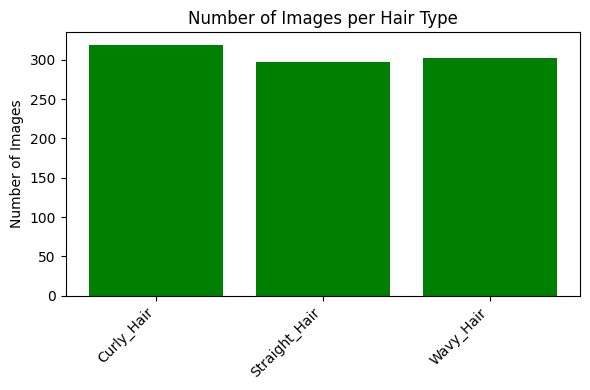

In [14]:
# Get the list of subdirectories in the data directory
subfolders = os.listdir(data_dir)

# Initialize a list to store the counts of images per subdirectory
image_counts = []

# Iterate over each subdirectory
for subfolder in subfolders:
    # Get the path to the subdirectory
    subfolder_path = os.path.join(data_dir, subfolder)
    # Count the number of image files in the subdirectory
    num_images = len([filename for filename in os.listdir(subfolder_path) if filename.endswith(".jpg") or filename.endswith(".png")])
    # Append the count to the list
    image_counts.append(num_images)

# Create the bar chart
plt.figure(figsize=(6, 4))
plt.bar(subfolders, image_counts, color='green')
plt.ylabel('Number of Images')
plt.title('Number of Images per Hair Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2.7. Apply Grayscale, Blur, and Sobel Edge Detection

In [15]:
# Define the directory containing the dataset image duplicates
data_dir_unedited = "hair_types_unedited"

In [16]:
# Loop through each subfolder
for hair_type in ["curly_hair", "straight_hair", "wavy_hair"]:
    # Get the path to the current subfolder
    hair_type_dir = os.path.join(data_dir, hair_type)
    
    # Create the unedited directory if it doesn't exist
    os.makedirs(data_dir_unedited, exist_ok=True)
    
    # Loop through each image file in the current subfolder
    for filename in tqdm(os.listdir(hair_type_dir)):
        # Get the path to the current image file
        img_path = os.path.join(hair_type_dir, filename)
        
        try:
            # Read the image
            img = cv2.imread(img_path)
            
            # Convert to graycsale
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Blur the image for better edge detection
            img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
            
            # Sobel Edge Detection
            sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
            sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
            sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
            
            # Save the image, overwriting the original file
            cv2.imwrite(img_path, sobelxy)
        
        except Exception as e:
            # If an error occurs, move the image to the unedited directory
            print(f"Error processing {img_path}: {str(e)}")
            shutil.move(img_path, os.path.join(data_dir_unedited, filename))

100%|███████████████████████████████████████████████████████████████████████████████| 337/337 [00:01<00:00, 215.62it/s]


Error processing hair_types\curly_hair\rs_1080x1080-200330130638-1080-ariana-grande-curly-hair-instagram-am-033020.gif: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'



100%|███████████████████████████████████████████████████████████████████████████████| 328/328 [00:01<00:00, 208.44it/s]


# 3. Using a DataLoader for Data Loading

## 3.1. Defining Seed

In [17]:
seed = 42
tf.random.set_seed(seed)

## 3.1. Define Training Set

In [18]:
# Create a TensorFlow dataset for training from images in the "hair_types/" directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",                         # Directory containing the image dataset
    validation_split=0.2,                  # Percentage of split of the data for validation
    subset="training",                     # Specify training subset
    seed=seed,                               # Starting point
    image_size=image_size,                 # Resize images to specified dimensions, set previously
    batch_size=batch_size,                 # Set batch size for training, set previously
    labels='inferred',                     # Infer class labels from directory structure
    label_mode='categorical'               # Use categorical labels (one-hot encoding)
)

Found 982 files belonging to 3 classes.
Using 786 files for training.


In [19]:
# Apply preprocessing to the dataset
# preprocessed_train_ds = train_ds.map(lambda x, y: (preprocess_image(x), y))

## 3.2. Define Validation Set

In [20]:
# Create a TensorFlow dataset for validation from images in the "hair_types/" directory
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",                         # Directory containing the image dataset
    validation_split=0.2,                  # Percentage of split of the data for validation
    subset="validation",                   # Specify validation subset
    seed=seed,                             # Starting point
    image_size=image_size,                 # Resize images to specified dimensions, set previously
    batch_size=batch_size,                 # Set batch size for training, set previously
    labels='inferred',                     # Infer class labels from directory structure
    label_mode='categorical'               # Use categorical labels (one-hot encoding)
)

Found 982 files belonging to 3 classes.
Using 196 files for validation.


In [21]:
# Apply preprocessing to the dataset
# preprocessed_val_ds = train_ds.map(lambda x, y: (preprocess_image(x), y))

# 3.3. Visualizing the Data

In [22]:
# Create a figure with a 10x10-inch size for displaying images
plt.figure(figsize=(10, 10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

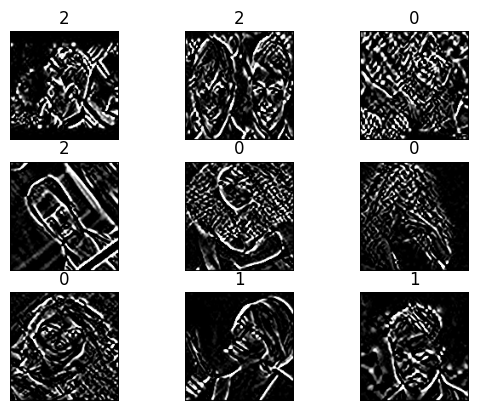

In [23]:
# Iterate over the first batch of images and labels in the preprocessed training dataset
for images, labels in train_ds.take(1):
    # Display the first 9 preprocessed images in a 3x3 grid
    for i in range(9):
        # Create a subplot for each image
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the preprocessed image as a numpy array and convert it to uint8 datatype
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')  # cmap='gray' for grayscale images
        
        # Set the title of the subplot to the integer label of the image
        plt.title(int(np.argmax(labels[i])))
        
        # Disable axis ticks and labels
        plt.axis("off")
# Display the plot
plt.show()

# 4. Creating the CNN Model

In [24]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print('GPU available.')
    # Set TensorFlow to utilize GPU memory dynamically
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
else:
    print('GPU not available.')

GPU not available.


In [25]:
# Create a Sequential model
model = Sequential()

# Add an input layer with the specified image size and 3 color channels
model.add(keras.Input(shape=image_size + (3,)))  # 64x64x3

# Normalize pixel values to the range [0, 1]
model.add(layers.Rescaling(1.0 / 255))

## 4.1. Adding Convolutional Layers with ReLU

In [26]:
# Add convolutional layers with ReLU activation
model.add(layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='same', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same')) # adding max pooling

model.add(layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same')) # adding max pooling

model.add(layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same')) # adding max pooling

# Add global average pooling layer
model.add(layers.GlobalAveragePooling2D())

# Add flatten
model.add(layers.Flatten())

In [27]:
# Add fully connected layers with ReLU activation
model.add(layers.Dense(64))
model.add(layers.Activation("relu"))

In [28]:
# Add dropout
model.add(layers.Dropout(0.3))

In [29]:
# Add output layer with softmax activation for multi-class classification
model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))

## 4.2. Saving CNN Architecture as an Image

In [30]:
# Plot the model architecture and save it as an image file
# tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

## 4.3. Model Summary

In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 3)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,339 (32.57 KB)

 Trainable params: 8,339 (32.57 KB)

 Non-trainable params: 0 (0.00 B)

## 4.3. Setting no. of Epochs or Iterations

In [32]:
# Set the number of training epochs or iterations
epochs = 50

In [33]:
# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

## 4.4. Model Callbacks

In [34]:
# Define a list of callbacks including EarlyStopping and TensorBoard
callbacks = [
    # EarlyStopping callback stops training if the validation loss stops decreasing for 3 consecutive epochs
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto'),
    # TensorBoard callback logs training metrics for visualization using TensorBoard
    tf.keras.callbacks.TensorBoard(log_dir='logs')]

## 4.5. CNN Model Fitting

### More info: https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [35]:
# Train the model on the training dataset, and validate on the validation dataset
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.3690 - loss: 1.0959 - val_accuracy: 0.3112 - val_loss: 1.0972
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4023 - loss: 1.0944 - val_accuracy: 0.3316 - val_loss: 1.0968
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3640 - loss: 1.0915 - val_accuracy: 0.4031 - val_loss: 1.0943
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4197 - loss: 1.0873 - val_accuracy: 0.4592 - val_loss: 1.0873
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4388 - loss: 1.0648 - val_accuracy: 0.3724 - val_loss: 1.0763
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4401 - loss: 1.0446 - val_accuracy: 0.3980 - val_loss: 1.0715
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4528 - loss: 1.0155 - val_accuracy: 0.4694 - val_loss: 1.0607
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5116 - loss: 0.9977 - val_accuracy: 0.4490 - v

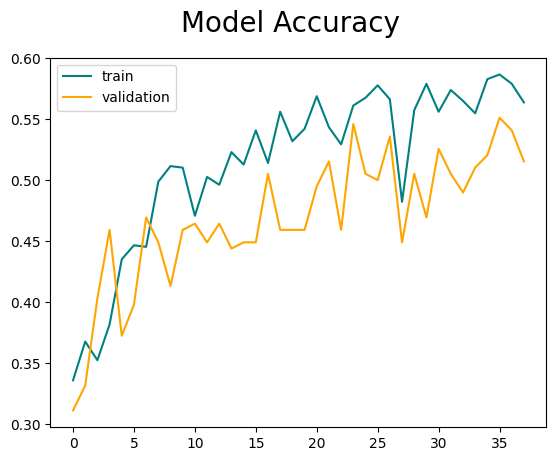

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='train')
plt.plot(hist.history['val_accuracy'], color='orange', label='validation')
fig.suptitle('Model Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 5. Predictions for Images

## 5.1. Selecting an Image for Evaluation & Prediction

In [37]:
# Load an image from the specified file path, resizing it to the target size
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", 
    target_size=image_size
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


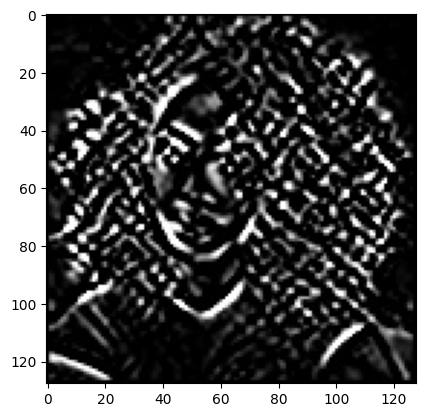

In [38]:
# Convert the loaded image to a NumPy array
img_array = keras.preprocessing.image.img_to_array(img)

# Add a batch axis to the image array to create a batch of size 1
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Use the trained model to make predictions on the image array
predictions = model.predict(img_array)

# Print the image
plt.imshow(img)

## 5.2. Making Predictions

In [39]:
# Print the predicted probabilities for each hair type
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)

# Find the index of the maximum probability
predicted_class_index = np.argmax(predictions[0])

# Define the class labels
class_labels = ["Curly Hair", "Straight Hair", "Wavy Hair"]

# Print the predicted image class
print("Predicted Image Class:", class_labels[predicted_class_index])

This image is 0.98 percent curly hair, 0.01 percent straight hair, and 0.01 percent wavy hair.
Predicted Image Class: Curly Hair


# 6. Visualizing Metrics & Results using TensorBoard

In [40]:
import webbrowser

# Launch TensorBoard to visualize training logs
webbrowser.open_new_tab('http://localhost:8088')
!tensorboard --logdir=logs/ --host localhost --port 8088

2024-04-19 11:31:00.912781: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-19 11:31:02.574915: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
W0419 11:31:06.640281 15124 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0419 11:31:06.650377 15124 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more grap